# Prepare Data and the Data Loader

In [2]:
import os
import glob
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive')

# Set directories
spec_dir = "/content/drive/MyDrive/multimodal_emotion_recognition/spectrograms"
emotion_map = {
    "neutral": 0,
    "calm": 1,
    "happy": 2,
    "sad": 3,
    "angry": 4,
    "fearful": 5,
    "disgust": 6,
    "surprised": 7
}

# Prepare dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, spec_dir, transform=None):
        self.spec_files = sorted(glob.glob(os.path.join(spec_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.spec_files)

    def __getitem__(self, idx):
        img_path = self.spec_files[idx]
        img = Image.open(img_path).convert('RGB')

        # Get the file name, and split it to extract the emotion label
        file_name = os.path.basename(img_path)  # Get only the file name, not the full path
        label = file_name.split('_')[0]  # Extract emotion

        # Map the label to the corresponding number
        label = emotion_map[label]  # Use the emotion_map dictionary

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for training and validation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fit model input
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pre-trained normalization
])

# Split the dataset into train and validation sets
dataset = SpectrogramDataset(spec_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoaders for batch processing
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Mounted at /content/drive


# Define the CNN Model

In [3]:
import torch.nn as nn
import torch.optim as optim


class SpectrogramCNN(nn.Module):
    def __init__(self):
        super(SpectrogramCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.4)

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 8)  # 8 emotion classes

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))
        x = self.pool(nn.ReLU()(self.conv2(x)))
        x = self.pool(nn.ReLU()(self.conv3(x)))

        x = x.view(-1, 64 * 16 * 16)  # Flatten

        x = self.dropout(nn.ReLU()(self.fc1(x)))  # FC1 + ReLU + Dropout
        x = self.fc2(x)  # Output layer

        return x


In [4]:
# Initialize the model
model = SpectrogramCNN()

# Train the Model

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print stats for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch [1/100], Loss: 2.0623, Accuracy: 14.84%
Epoch [2/100], Loss: 1.9654, Accuracy: 23.26%
Epoch [3/100], Loss: 1.7969, Accuracy: 30.56%
Epoch [4/100], Loss: 1.6472, Accuracy: 38.98%
Epoch [5/100], Loss: 1.5406, Accuracy: 43.84%
Epoch [6/100], Loss: 1.4684, Accuracy: 46.79%
Epoch [7/100], Loss: 1.3774, Accuracy: 47.40%
Epoch [8/100], Loss: 1.3241, Accuracy: 50.00%
Epoch [9/100], Loss: 1.2536, Accuracy: 54.60%
Epoch [10/100], Loss: 1.1913, Accuracy: 54.95%
Epoch [11/100], Loss: 1.1357, Accuracy: 55.64%
Epoch [12/100], Loss: 1.1292, Accuracy: 59.46%
Epoch [13/100], Loss: 1.0660, Accuracy: 61.28%
Epoch [14/100], Loss: 1.0659, Accuracy: 61.81%
Epoch [15/100], Loss: 0.9685, Accuracy: 64.32%
Epoch [16/100], Loss: 0.9124, Accuracy: 67.45%
Epoch [17/100], Loss: 0.9437, Accuracy: 64.58%
Epoch [18/100], Loss: 0.8532, Accuracy: 70.31%
Epoch [19/100], Loss: 0.7949, Accuracy: 71.18%
Epoch [20/100], Loss: 0.8126, Accuracy: 69.88%
Epoch [21/100], Loss: 0.7753, Accuracy: 71.18%
Epoch [22/100], Loss: 

# Validate the Model

In [6]:
# Evaluation loop
model.eval()  # Set model to evaluation mode
val_correct = 0
val_total = 0

with torch.no_grad():  # No gradients needed for validation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)

        val_total += labels.size(0)
        val_correct += (predicted == labels).sum().item()

# Print accuracy for validation
print(f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

Validation Accuracy: 75.00%


# Using a Pre-Trained ResNet

## Defining the ResNet

In [7]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetEmotionClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNetEmotionClassifier, self).__init__()

        # Load pretrained ResNet18
        self.base_model = models.resnet18(pretrained=True)

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.base_model(x)


In [8]:
model = ResNetEmotionClassifier(num_classes=8)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


## Modifying Data for the ResNet

In [9]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize spectrograms to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # ImageNet means
                         std=[0.229, 0.224, 0.225])    # ImageNet stds
])


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import os

class SpectrogramDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, fname)
                            for fname in os.listdir(image_dir) if fname.endswith(".png")]

        self.emotion_map = {
            'neutral': 0, 'calm': 1, 'happy': 2, 'sad': 3,
            'angry': 4, 'fearful': 5, 'disgust': 6, 'surprised': 7
        }

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel input

        label_str = os.path.basename(img_path).split('_')[0]
        label = self.emotion_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


## Setting up Data Loader

In [11]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

dataset = SpectrogramDataset(image_dir='/content/drive/MyDrive/multimodal_emotion_recognition/spectrograms', transform=transform)

train_indices, val_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training the ResNet

In [12]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetEmotionClassifier(num_classes=8).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        val_loss, val_correct = 0.0, 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        # Epoch Summary
        train_acc = train_correct / len(train_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

In [13]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

Epoch 1/20: Train Loss: 1997.6796, Acc: 0.3507 | Val Loss: 378.7998, Acc: 0.5660
Epoch 2/20: Train Loss: 1034.4657, Acc: 0.7066 | Val Loss: 288.1685, Acc: 0.6354
Epoch 3/20: Train Loss: 460.3545, Acc: 0.9141 | Val Loss: 244.0325, Acc: 0.7083
Epoch 4/20: Train Loss: 169.7251, Acc: 0.9861 | Val Loss: 236.2055, Acc: 0.6979
Epoch 5/20: Train Loss: 77.3463, Acc: 0.9974 | Val Loss: 228.2406, Acc: 0.7188
Epoch 6/20: Train Loss: 46.9799, Acc: 0.9974 | Val Loss: 227.0181, Acc: 0.7257
Epoch 7/20: Train Loss: 28.5324, Acc: 1.0000 | Val Loss: 220.9486, Acc: 0.7396
Epoch 8/20: Train Loss: 17.1158, Acc: 1.0000 | Val Loss: 215.0876, Acc: 0.7431
Epoch 9/20: Train Loss: 14.9466, Acc: 1.0000 | Val Loss: 217.0663, Acc: 0.7326
Epoch 10/20: Train Loss: 11.8617, Acc: 1.0000 | Val Loss: 223.5200, Acc: 0.7326
Epoch 11/20: Train Loss: 12.4491, Acc: 1.0000 | Val Loss: 232.1200, Acc: 0.7292
Epoch 12/20: Train Loss: 10.9495, Acc: 1.0000 | Val Loss: 220.5418, Acc: 0.7396
Epoch 13/20: Train Loss: 8.3951, Acc: 1.000

## Evaluate Model

Classification Report:

              precision    recall  f1-score   support

     neutral       0.44      0.86      0.59        14
        calm       0.80      0.85      0.82        33
       happy       0.65      0.65      0.65        48
         sad       0.69      0.48      0.56        42
       angry       0.81      0.79      0.80        38
     fearful       0.73      0.82      0.77        39
     disgust       0.82      0.77      0.79        35
   surprised       0.94      0.85      0.89        39

    accuracy                           0.74       288
   macro avg       0.73      0.76      0.73       288
weighted avg       0.75      0.74      0.74       288



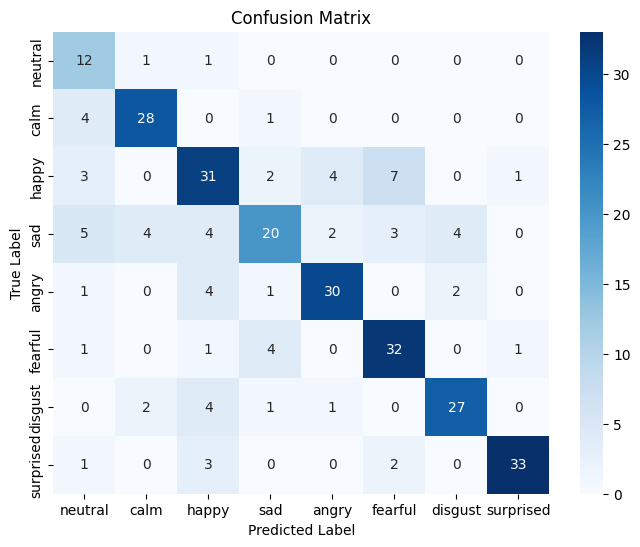

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

class_names = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

evaluate_model(model, val_loader, class_names)
